# Finishing 3rd Party Work by Predicting Customer Loyalties Using ML 


## Table of contents

- [00. Project Overview](#overview-main)
    - [Context](#overview-context)
    - [Actions](#overview-actions)
    - [Results](#overview-results)
    - [Considerations/Next Steps](#overview-growth)
- [01. Data Overview](#data-overview)
- [02. Data Import, EDA and Preprocessing](#eda-overview)
- [03. Logistic Regression](#logreg-title)
- [04. Decision Tree](#clftree-title)
- [05. Random Forest](#rf-title)
- [07. Prediction](#prediction)

## Project Overview <a name="overview-main"></a>

### Context <a name="overview-context"></a>

Client we are working with hired a 3rd party consulting company to perform work necessary to match a customer loyalty value to the respective customer shopping at the store. 

The consulting group only managed to complete half of the work leaving the store with another half of customers to determine if they do or do not have a customer loyalty score. 

The client sent an email to see if our data analytics group could possibly help with finishing off the work with our new learned skills. They'd like us to **predict the remaining customer loyalty scores with the respective customers associated to** given the data tracked by the customers and the already associated loyalty scores.

We will be using Machine Learning for this task!


### Actions <a name="overview-actions"></a>

1. Gather the data 
2. Identify the most valuable inputs
3. Scrub and prepare the data
4. Identify ML tools that would work best with this problem
    - Logistic Regression
    - Decision Tree
    - Random Forest
5. Assess ML outputs (and rework where ever possible) to best arguably determine the scores
6. Provide client with determined customer loyalty scores

This notebook goes through all those steps.




### Results <a name="overview-results"></a>

Team was able to successfully predict the rest of the customers loyalty scores (whether they did have one or not). 

The model most relied on was the random forest which gave the team the best confidence (as seen below) of predicting the loyalty scores to the customers given the already scores listed from the first half.

1. Logistic Regression: 0.754 
2. Decision Trees: 0.875
3. Random Forest: 0.910


### Considerations/Next Steps <a name="overview-growth"></a>



While predictive accuracy was relatively high - other modelling approaches could be tested to see if even more accuracy could be gained. But a word of caution here, we have to know when to call a model 'good enough' and that is usually decided prior to building the model.

From a data point of view, further variables could be collected, and further feature engineering could be undertaken to ensure that we have as much useful information available for predicting customer loyalty.

Other considerations:

1. Normally we would spend more time/work on the data we removed due to **NA**. A Justification was made to simply remove since the impact of the removed would have not changed drastically the predictions. About **.061%** of a difference.

2. For the Logistic Regression we removed the outliers without too much though of understanding the reason for those outliers which usually we would need to understand more.

## Data Overview <a name="data-overview"></a>

We will be predicting the loyalty scores seen in *customer_loyalty_score* from company provided *grocery_database.xlsx* in client database.

Variables used to predict come from client database, namely *transactions* table, *customer_details* table, and *loyalty_scores* table.

After pre-processing data in Python, dataset for modelling contains following information...
<br>
<br>

| **Variable Name** | **Variable Type** | **Description** |
|---|---|---|
| customer_id | Dependent | The individual customer |
| distance_from_store | Independent | The distance in miles from the customers home address, and the store |
| gender | Independent | The gender provided by the customer |
| credit_score | Independent | The customers most recent credit score |
| customer_loyalty_score | Independent | Associated score giben to the individual customer |
| total_sales | Independent | Total spend by the customer in Grocery store - 3 months pre campaign |
| total_items | Independent | Total products purchased by the customer in Grocery store - 3 months pre campaign |
| transaction_count | Independent | Total unique transactions made by the customer in ABC Grocery - 3 months pre campaign |
| product_area_count | Independent | The number of product areas within Grocery store the customers has shopped into - 3 months pre campaign |
| average_basket_value | Independent | The average spend per transaction for the customer in Grocery store - 3 months pre campaign |


## Imports and Preprocessing <a name="eda-overview"></a>

In [57]:
# import required packages
import pandas as pd
import pickle
# import required packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [58]:
# import Data
data_path = "C:/Users/eacalder/Documents/Education/DataScienceInfinity/Leasson_Downloads/ABTesting/grocery_database.xlsx"
loyalty_scores = pd.read_excel(data_path, sheet_name = 'loyalty_scores') 
customer_details = pd.read_excel(data_path, sheet_name = 'customer_details') 
transactions = pd.read_excel(data_path, sheet_name = 'transactions') 
print(loyalty_scores.shape)
loyalty_scores.head()

(400, 2)


,customer_id,customer_loyalty_score
0,104,0.587
1,69,0.156
2,525,0.959
3,181,0.418
4,796,0.570


In [59]:
print(customer_details.shape)
customer_details.head()

(870, 4)


,customer_id,distance_from_store,gender,credit_score
0,74,3.38,F,0.59
1,524,4.76,F,0.52
2,607,4.45,F,0.49
3,343,0.91,M,0.54
4,322,3.02,F,0.63


In [60]:
print(transactions.shape)
transactions.head()

(38506, 6)


,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [61]:
# Create customer level data set
data_for_regression = pd.merge(customer_details,
                               loyalty_scores, 
                               how='left', 
                               on='customer_id')
print(data_for_regression.shape)
data_for_regression.head(7)

(870, 5)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score
0,74,3.38,F,0.59,0.263
1,524,4.76,F,0.52,0.298
2,607,4.45,F,0.49,0.337
3,343,0.91,M,0.54,0.873
4,322,3.02,F,0.63,0.350
5,115,1.02,M,0.64,0.751
6,1,4.78,F,0.66,NaN


you can clearly see some customers that do not have a loyalty score

In [62]:
# grouping by the customer id since we are finding per customer
# and adding more input variables that will most likely help the model to predict
sales_summary =  transactions.groupby('customer_id').agg({'sales_cost':'sum',
                                                          'num_items':'sum',
                                                          'transaction_id':'count',
                                                          'product_area_id': 'nunique'}).reset_index()
print(sales_summary.shape)
sales_summary.head()

(870, 5)


,customer_id,sales_cost,num_items,transaction_id,product_area_id
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


In [63]:
sales_summary.columns = ['customer_id', 
                         'total_sales',
                         'total_items',
                         'transaction_count', 
                         'product_area_count']
print(sales_summary.shape)
sales_summary.head()

(870, 5)


,customer_id,total_sales,total_items,transaction_count,product_area_count
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


In [64]:
# we believe adding the basket value will help with customer loyalty since that 
# number shows on average the spending to the grocery store
sales_summary['avg_basket_value'] = sales_summary['total_sales']/sales_summary['transaction_count']
print(sales_summary.shape)
sales_summary.head()

(870, 6)


,customer_id,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,1,3980.49,424,51,5,78.048824
1,2,2056.91,213,52,5,39.555962
2,3,324.22,65,12,4,27.018333
3,4,3499.39,278,47,5,74.455106
4,5,6609.19,987,106,5,62.350849


In [65]:

data_for_regression_2 = pd.merge(data_for_regression,
                               sales_summary, 
                               how='inner', 
                               on='customer_id')
print(data_for_regression_2.shape)
data_for_regression_2.head(7)
# managed to gather all metrics that will help the machine 
# learning model to predict the other 
# half of the customers loyalty score

(870, 10)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800
5,115,1.02,M,0.64,0.751,2490.66,263,51,5,48.836471
6,1,4.78,F,0.66,NaN,3980.49,424,51,5,78.048824


we seperate the tables one used to prepare our model with and with the customer loyalty scores 
AND
one with customers without the loyalty scores 

In [66]:
regression_modeling = data_for_regression_2.\
                        loc[data_for_regression_2['customer_loyalty_score'].\
                        notna()]
regression_scoring = data_for_regression_2.\
                        loc[data_for_regression_2['customer_loyalty_score'].\
                        isna()]
print(regression_modeling.shape)
regression_modeling.head()

(400, 10)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [67]:
print(regression_scoring.shape)
regression_scoring.head()

(470, 10)


,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
6,1,4.78,F,0.66,NaN,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,NaN,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,NaN,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,NaN,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,NaN,3448.59,370,49,5,70.379388


In [68]:
regression_scoring.drop(['customer_loyalty_score'],axis=1,inplace=True)
print(regression_scoring.shape)
regression_scoring.head()

(470, 9)


C:\Users\eacalder\AppData\Local\Temp\1/ipykernel_24472/3055292113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_scoring.drop(['customer_loyalty_score'],axis=1,inplace=True)


,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


In [69]:
# save our files
pickle.dump(regression_modeling,open('Saved_files/Groc_regression_modeling.p','wb'))
pickle.dump(regression_scoring,open('Saved_files/Groc_regression_scoring.p','wb'))

In [70]:
# import, learning to import using pickle files
data_for_model = pickle.load(open('Saved_files/Groc_regression_modeling.p','rb'))

# we dont really need the id for the model
data_for_model.drop('customer_id', axis=1, inplace=True)
print(data_for_model.shape)
data_for_model.head()

(400, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [71]:
# shuffle data just in case it either came in in some order
# or we accidentally ordered it which will cause model to error
data_for_model = shuffle(data_for_model,random_state=42)
print(data_for_model.shape)
data_for_model.head()

(400, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [72]:
######################################################
# deal with missing values
######################################################
data_for_model.isna().sum()
# small number of columns with missing values, lets not impute and just drop 
# but noted 

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
avg_basket_value          0
dtype: int64

In [73]:
# "any" meaning drop the whole row if any one cell is empty
data_for_model.dropna(how="any", inplace=True)
print(data_for_model.shape)
data_for_model.head()

(394, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


# Logistic Regression <a name="logreg-title"></a>

In [74]:
data_for_model_logreg = data_for_model
data_for_model_logreg.head()

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [75]:
######################################################
# deal with outliers
######################################################
outlier_investigation = data_for_model_logreg.describe()
print(outlier_investigation)
# some outliers in distance_from_store, total_sales, total_items
# all others did not spark any issues

       distance_from_store  credit_score  customer_loyalty_score  total_sales  \
count           394.000000    394.000000              394.000000   394.000000   
mean              2.021041      0.596117                0.509589  1846.502538   
std               2.566045      0.101352                0.294504  1767.829482   
min               0.000000      0.260000                0.002000    45.950000   
25%               0.710000      0.530000                0.263000   942.067500   
50%               1.645000      0.590000                0.510500  1471.490000   
75%               2.910000      0.660000                0.771500  2104.727500   
max              44.370000      0.880000                1.000000  9878.760000   

       total_items  transaction_count  product_area_count  avg_basket_value  
count   394.000000         394.000000          394.000000        394.000000  
mean    278.304569          44.926396            4.312183         36.781487  
std     214.236424          21.24801

In [76]:
# boxplot approach remove outliers
outlier_columns = ["distance_from_store", "total_sales", "total_items"]
for column in outlier_columns:
    lower_quartile = data_for_model_logreg[column].quantile(.25)
    upper_quartile = data_for_model_logreg[column].quantile(.75)
    iqr= upper_quartile - lower_quartile
    iqr_extend = iqr *2 # 1.5 reason i dont want to cut out too many outliers
    min_border = lower_quartile - iqr_extend
    max_border = upper_quartile + iqr_extend

    outliers = data_for_model_logreg[(data_for_model_logreg[column]<min_border)|(data_for_model_logreg[column]>max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")

    data_for_model_logreg.drop(outliers,inplace=True)

print(data_for_model_logreg.shape)
data_for_model_logreg.head()


2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items
(369, 9)


,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [77]:
######################################################
# split input variables and output variables
######################################################
# we dont want the output in the input dataframe
X = data_for_model_logreg.drop(['customer_loyalty_score'], axis=1)
Y = data_for_model_logreg['customer_loyalty_score']

In [78]:
######################################################
# split out training and test sets
######################################################
# Regression model 
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.2,
                                                    random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(295, 8)
(74, 8)
(295,)
(74,)


In [79]:
######################################################
# deal with categorical variables
######################################################
# gender
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")# array is easier to use and viduallize 
# avoid dummy variable trap

In [80]:
# fit and transform on the training and only the transform on the test
# we do this because we want the encoding rules to be learned from the 
# training data and then applied to the new data 
X_train_encoded_vars_array = one_hot_encoder.fit_transform(x_train[categorical_vars])
X_test_encoded_vars_array = one_hot_encoder.transform(x_test[categorical_vars])
print(X_train_encoded_vars_array.shape)
print(X_test_encoded_vars_array.shape)

(295, 1)
(74, 1)


c:\Users\eacalder\.conda\envs\DSInfinity\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [81]:
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [82]:
X_train_encoded_vars_array = pd.DataFrame(X_train_encoded_vars_array,
                               columns=encoder_feature_names)
x_train = pd.concat([x_train.reset_index(drop=True),
                   X_train_encoded_vars_array.reset_index(drop=True)], 
                   axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_train.drop(categorical_vars, axis=1,inplace=True)
print(x_train.shape)
print(x_train.head())

(295, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 0.19          0.57      1096.96          202   
1                 0.39          0.43       933.39          220   
2                 2.27          0.49      1506.49          281   
3                 3.10          0.59       330.79           81   
4                 0.07          0.53      2053.04          210   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 53                   5         20.697358       1.0  
1                 51                   4         18.301765       1.0  
2                 47                   3         32.052979       0.0  
3                 13                   4         25.445385       0.0  
4                 54                   5         38.019259       1.0  


In [83]:
X_test_encoded_vars_array = pd.DataFrame(X_test_encoded_vars_array,
                               columns=encoder_feature_names)
x_test = pd.concat([x_test.reset_index(drop=True),
                   X_test_encoded_vars_array.reset_index(drop=True)], axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_test.drop(categorical_vars, axis=1,inplace=True)
print(x_test.shape)
print(x_test.head())

(74, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 2.80          0.41      1524.01          278   
1                 1.92          0.64      1992.51          305   
2                 4.38          0.47       343.41           70   
3                 1.51          0.59      1208.91          198   
4                 2.52          0.50      1967.39          316   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 45                   3         33.866889       0.0  
1                 53                   5         37.594528       0.0  
2                 12                   4         28.617500       0.0  
3                 55                   5         21.980182       0.0  
4                 55                   5         35.770727       0.0  


In [84]:
######################################################
# feature selection
######################################################
regressor = LinearRegression()
feature_selector = RFECV(regressor)

# trains the model and assess
fit = feature_selector.fit(x_train,y_train)
print(fit)

RFECV(estimator=LinearRegression())


In [85]:
optimal_feature_count = feature_selector.n_features_
print(f"optimal number features: {optimal_feature_count}")
#it says 8 which is all of them

optimal number features: 8


In [86]:
# we didnt really need to tun this becuse it sugested 
# all 8 columns but i ran just cause 
x_train  = x_train.loc[:,feature_selector.get_support()]
x_test  = x_test.loc[:,feature_selector.get_support()]
print(x_train)
print(x_test)

     distance_from_store  credit_score  total_sales  total_items  \
0                   0.19          0.57      1096.96          202   
1                   0.39          0.43       933.39          220   
2                   2.27          0.49      1506.49          281   
3                   3.10          0.59       330.79           81   
4                   0.07          0.53      2053.04          210   
..                   ...           ...          ...          ...   
290                 1.02          0.64      2490.66          263   
291                 0.66          0.45      3183.80          285   
292                 2.60          0.48      1815.22          306   
293                 1.81          0.54      1208.05          272   
294                 2.94          0.62      2397.63          282   

     transaction_count  product_area_count  avg_basket_value  gender_M  
0                   53                   5         20.697358       1.0  
1                   51               

in the other approaches there was guess work where as here it cut a lot of this and able to get reliable stuff

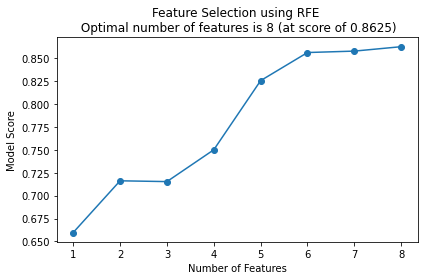

In [87]:
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), 
         fit.cv_results_['mean_test_score'], 
         marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

In [88]:
######################################################
# model train
######################################################
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

In [89]:
######################################################
# model assessment
######################################################
# Predict on the Test Set 
y_pred = regressor.predict(x_test)

In [90]:
# Calculate R-Squared 
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.7805702910327413


In [91]:
# Cross Validation 
cv = KFold(n_splits=4,shuffle=True,random_state=42)
cv_scores =cross_val_score(regressor,x_train,y_train,cv=cv,scoring="r2")
print(cv_scores)

[0.8427758  0.86000619 0.8913188  0.81883022]


In [92]:
cv_scores.mean()

0.8532327536589741

In [93]:
# Calculate Adjusted R-Squared
num_data_points, num_input_vars = x_test.shape 
print(x_test.shape) 

(74, 8)


In [94]:
adjusted_r_squared = 1-(1-r_squared)*(num_data_points-1)/(num_data_points-num_input_vars-1)
print(adjusted_r_squared) 

0.7535635576213864


We get an accuracy of 0.754 which is ok, but I think we can do better. Below I hilight what the coefficents and the intercept of the best fit equation

In [95]:
# Extract Model Coefficients
coefficients = pd.DataFrame(regressor.coef_)  
print(coefficients) 

          0
0 -0.201232
1 -0.027697
2  0.000142
3  0.001002
4 -0.004842
5  0.061659
6 -0.003971
7 -0.013393


In [96]:
input_variable_names = pd.DataFrame(x_train.columns)
summary_stats = pd.concat([input_variable_names,coefficients],axis=1)
summary_stats.columns = ['input_variable', 'coefficients']
print(summary_stats)

        input_variable  coefficients
0  distance_from_store     -0.201232
1         credit_score     -0.027697
2          total_sales      0.000142
3          total_items      0.001002
4    transaction_count     -0.004842
5   product_area_count      0.061659
6     avg_basket_value     -0.003971
7             gender_M     -0.013393


In [97]:
# Extract Model Intercept
regressor.intercept_

0.5160974174646102

# Decision Trees <a name="clftree-title"></a>

In [98]:
data_for_model_tree = data_for_model

In [99]:
######################################################
# split input variables and output variables
######################################################
# we dont want the output in the input dataframe
X = data_for_model_tree.drop(['customer_loyalty_score'], axis=1)
Y = data_for_model_tree['customer_loyalty_score']

In [100]:
######################################################
# split out training and test sets
######################################################
# Regression model 
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.2,
                                                    random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(295, 8)
(74, 8)
(295,)
(74,)


In [101]:
######################################################
# deal with categorical variables
######################################################
# gender
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")# array is easier to use and viduallize 
# avoid dummy variable trap

In [102]:
# fit and transform on the training and only the transform on the test
# we do this because we want the encoding rules to be learned from the 
# training data and then applied to the new data 
X_train_encoded_vars_array = one_hot_encoder.fit_transform(x_train[categorical_vars])
X_test_encoded_vars_array = one_hot_encoder.transform(x_test[categorical_vars])
print(X_train_encoded_vars_array.shape)
print(X_test_encoded_vars_array.shape)

(295, 1)
(74, 1)


c:\Users\eacalder\.conda\envs\DSInfinity\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [103]:

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [104]:
X_train_encoded_vars_array = pd.DataFrame(X_train_encoded_vars_array,
                               columns=encoder_feature_names)
x_train = pd.concat([x_train.reset_index(drop=True),
                   X_train_encoded_vars_array.reset_index(drop=True)], 
                   axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_train.drop(categorical_vars, axis=1,inplace=True)
print(x_train.shape)
print(x_train.head())

(295, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 0.19          0.57      1096.96          202   
1                 0.39          0.43       933.39          220   
2                 2.27          0.49      1506.49          281   
3                 3.10          0.59       330.79           81   
4                 0.07          0.53      2053.04          210   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 53                   5         20.697358       1.0  
1                 51                   4         18.301765       1.0  
2                 47                   3         32.052979       0.0  
3                 13                   4         25.445385       0.0  
4                 54                   5         38.019259       1.0  


In [105]:
X_test_encoded_vars_array = pd.DataFrame(X_test_encoded_vars_array,
                               columns=encoder_feature_names)
x_test = pd.concat([x_test.reset_index(drop=True),
                   X_test_encoded_vars_array.reset_index(drop=True)], axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_test.drop(categorical_vars, axis=1,inplace=True)
print(x_test.shape)
print(x_test.head())

(74, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 2.80          0.41      1524.01          278   
1                 1.92          0.64      1992.51          305   
2                 4.38          0.47       343.41           70   
3                 1.51          0.59      1208.91          198   
4                 2.52          0.50      1967.39          316   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 45                   3         33.866889       0.0  
1                 53                   5         37.594528       0.0  
2                 12                   4         28.617500       0.0  
3                 55                   5         21.980182       0.0  
4                 55                   5         35.770727       0.0  


below each variable is judges indenpendently 
if high input variables, doing below will help for computation and alot of input variable

In [106]:
######################################################
# model train
######################################################
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(x_train,y_train)

DecisionTreeRegressor(random_state=42)

In [107]:
######################################################
# model assessment
######################################################
# Predict on the Test Set 
y_pred = regressor.predict(x_test)

In [108]:
# Calculate R-Squared 
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.8894229399071569


So our model is getting better, I want to validate this score and try different folds to see if we actually get this same score on average.

In [109]:
# Cross Validation 
cv = KFold(n_splits=4,shuffle=True,random_state=42)
cv_scores =cross_val_score(regressor,x_train,y_train,cv=cv,scoring="r2")
print(cv_scores)

[0.82815691 0.84726946 0.83878834 0.86335605]


In [110]:
cv_scores.mean()

0.8443926914644135

In [111]:
# Calculate Adjusted R-Squared
num_data_points, num_input_vars = x_test.shape 
print(x_test.shape) 

(74, 8)


In [112]:
adjusted_r_squared = 1-(1-r_squared)*(num_data_points-1)/(num_data_points-num_input_vars-1)
print(adjusted_r_squared) 

0.8758134555880378


Ok, our accuracy:
1. Logistic Regression: 0.754 
2. Decision Trees: 0.876

So our model is getting better, think I want to try random forest to see if we can be more accurate.

First I want to try different folds to see if we can bump this up and if changing the depths helps this figure since we didnt really specify in the beginning.

Below I wanted to validate myself by changing the depths to ensure I understood the process of overfitting

In [113]:
# demonstration of over fitting
# decision trees are prone to this

# assess model accuracy
y_pred_training = regressor.predict(x_train)
r2_score(y_train,y_pred_training)

1.0

In [114]:
# finding the best max depth
max_depth_list = list(range(1,9))
accuracy_scores = []

for depth in max_depth_list:
    regressor = DecisionTreeRegressor(max_depth=depth,random_state=42)
    regressor.fit(x_train,y_train)
    y_pred = regressor.predict(x_test)
    accuracy = r2_score(y_test,y_pred)
    accuracy_scores.append(accuracy)
print(accuracy_scores)

[0.4364037494549644, 0.5848135594639989, 0.7206309355762486, 0.8292106691439445, 0.856640703864234, 0.8785569062539205, 0.8469439643502296, 0.9024600986606706]


In [115]:
max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_idx]
print(optimal_depth)

8


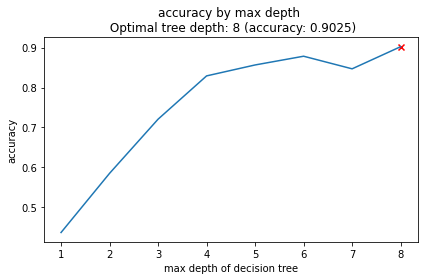

In [116]:
# plot of max depths
plt.plot(max_depth_list,accuracy_scores)
plt.scatter(optimal_depth,
            max_accuracy,
            marker='x',
            color='red')
plt.title(f'accuracy by max depth \n Optimal tree depth: {optimal_depth} (accuracy: {round(max_accuracy,4)})')
plt.xlabel('max depth of decision tree')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()


In [117]:
######################################################
# model train
######################################################
regressor = DecisionTreeRegressor(random_state=42,max_depth=4)
regressor.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [118]:
######################################################
# model assessment
######################################################
# Predict on the Test Set 
y_pred = regressor.predict(x_test)
# Calculate R-Squared 
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.8292106691439445


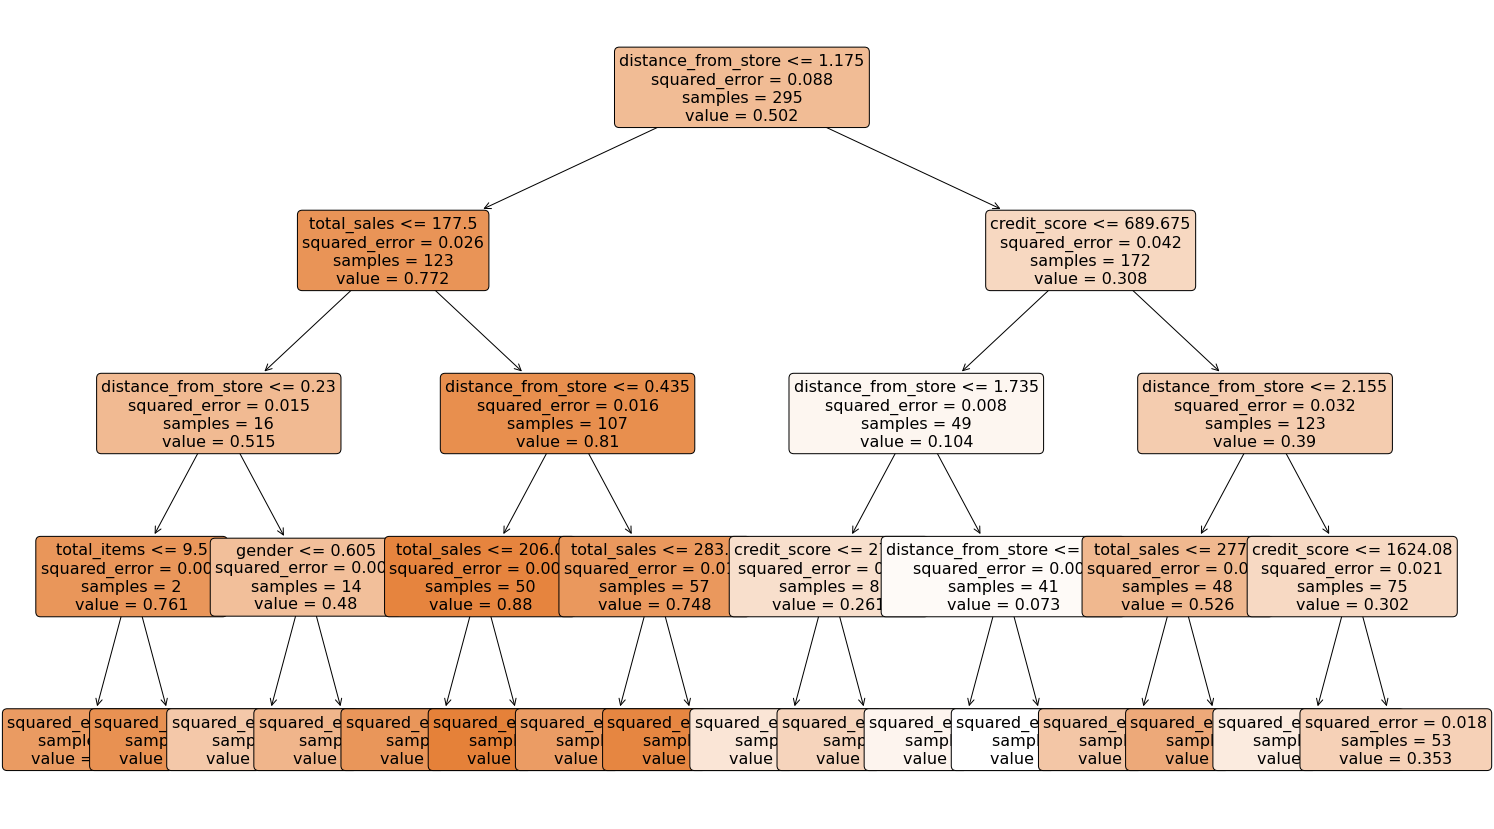

In [119]:
# plot our model
# plot our decision tree
plt.figure(figsize=(25,15))
tree = plot_tree(regressor,
                 feature_names=X.columns,
                 filled=True,
                 rounded = True,
                 fontsize=16)

# Random Forest <a name="rf-title"></a>

In [120]:
data_for_model_ranfor = data_for_model

removing outliers for trees wont change anything so it is not necessary to run the logic on them for both random forest and tree regression

In [121]:
######################################################
# split input variables and output variables
######################################################
# we dont want the output in the input dataframe
X = data_for_model_ranfor.drop(['customer_loyalty_score'], axis=1)
Y = data_for_model_ranfor['customer_loyalty_score']

In [122]:
######################################################
# split out training and test sets
######################################################
# Regression model 
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.2,
                                                    random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(295, 8)
(74, 8)
(295,)
(74,)


In [123]:
######################################################
# deal with categorical variables
######################################################
# gender
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")# array is easier to use and viduallize 
# avoid dummy variable trap

In [124]:
# fit and transform on the training and only the transform on the test
# we do this because we want the encoding rules to be learned from the 
# training data and then applied to the new data 
X_train_encoded_vars_array = one_hot_encoder.fit_transform(x_train[categorical_vars])
X_test_encoded_vars_array = one_hot_encoder.transform(x_test[categorical_vars])
print(X_train_encoded_vars_array.shape)
print(X_test_encoded_vars_array.shape)

(295, 1)
(74, 1)


c:\Users\eacalder\.conda\envs\DSInfinity\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [125]:
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [126]:
X_train_encoded_vars_array = pd.DataFrame(X_train_encoded_vars_array,
                               columns=encoder_feature_names)
x_train = pd.concat([x_train.reset_index(drop=True),
                   X_train_encoded_vars_array.reset_index(drop=True)], 
                   axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_train.drop(categorical_vars, axis=1,inplace=True)
print(x_train.shape)
print(x_train.head())

(295, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 0.19          0.57      1096.96          202   
1                 0.39          0.43       933.39          220   
2                 2.27          0.49      1506.49          281   
3                 3.10          0.59       330.79           81   
4                 0.07          0.53      2053.04          210   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 53                   5         20.697358       1.0  
1                 51                   4         18.301765       1.0  
2                 47                   3         32.052979       0.0  
3                 13                   4         25.445385       0.0  
4                 54                   5         38.019259       1.0  


In [127]:
X_test_encoded_vars_array = pd.DataFrame(X_test_encoded_vars_array,
                               columns=encoder_feature_names)
x_test = pd.concat([x_test.reset_index(drop=True),
                   X_test_encoded_vars_array.reset_index(drop=True)], axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_test.drop(categorical_vars, axis=1,inplace=True)
print(x_test.shape)
print(x_test.head())

(74, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 2.80          0.41      1524.01          278   
1                 1.92          0.64      1992.51          305   
2                 4.38          0.47       343.41           70   
3                 1.51          0.59      1208.91          198   
4                 2.52          0.50      1967.39          316   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 45                   3         33.866889       0.0  
1                 53                   5         37.594528       0.0  
2                 12                   4         28.617500       0.0  
3                 55                   5         21.980182       0.0  
4                 55                   5         35.770727       0.0  


In [128]:
######################################################
# model train
######################################################
regressor = RandomForestRegressor(random_state=42)
regressor.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [129]:
######################################################
# model assessment
######################################################
# Predict on the Test Set 
y_pred = regressor.predict(x_test)

In [130]:
# Calculate R-Squared 
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.9201991316592083


In [131]:
# Cross Validation 
cv = KFold(n_splits=4,shuffle=True,random_state=42)
cv_scores =cross_val_score(regressor,x_train,y_train,cv=cv,scoring="r2")
print(cv_scores)

[0.89839223 0.92193768 0.92931663 0.93950913]


In [132]:
cv_scores.mean()

0.9222889175959589

In [133]:
# Calculate Adjusted R-Squared
num_data_points, num_input_vars = x_test.shape 
print(x_test.shape) 

(74, 8)


In [134]:
adjusted_r_squared = 1-(1-r_squared)*(num_data_points-1)/(num_data_points-num_input_vars-1)
print(adjusted_r_squared) 

0.910377486324957


feature importance! 

In [135]:
feature_importance = pd.DataFrame(regressor.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance],
                                       axis = 1)
feature_importance_summary.columns = ['input_variable', 'feature_importance']
feature_importance_summary.sort_values(by='feature_importance',inplace=True)
feature_importance_summary.head()

,input_variable,feature_importance
7,avg_basket_value,0.000587
1,gender,0.011145
6,product_area_count,0.013141
5,transaction_count,0.016667
4,total_items,0.029299


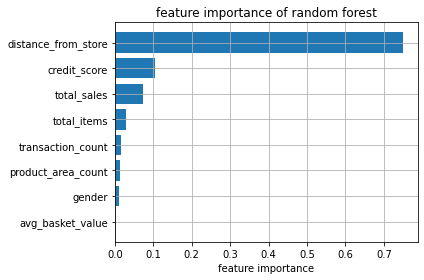

In [136]:
plt.barh(feature_importance_summary['input_variable'],feature_importance_summary['feature_importance'])
plt.title("feature importance of random forest")
plt.xlabel("feature importance")
# plt.ylabel("y label")
plt.tight_layout()
plt.grid(True)
plt.show()

we have the feature importance, another way of calculating this out is by 

permutation importance - more advised to use 

In [137]:
result = permutation_importance(regressor, 
                                x_test, 
                                y_test, 
                                n_repeats=10,
                                random_state=42)
# print(result)

In [138]:
permutation_importance = pd.DataFrame(result['importances_mean'])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],
                                       axis = 1)
permutation_importance_summary.columns = ['input_variable', 'feature_importance']
permutation_importance_summary.sort_values(by='feature_importance',inplace=True)
permutation_importance_summary.head()

,input_variable,feature_importance
1,gender,-0.000400
7,avg_basket_value,0.000639
6,product_area_count,0.005867
4,total_items,0.006627
5,transaction_count,0.016121


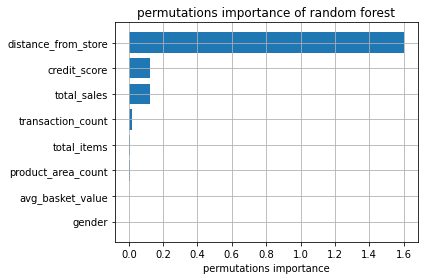

In [139]:
plt.barh(permutation_importance_summary['input_variable'],permutation_importance_summary['feature_importance'])
plt.title("permutations importance of random forest")
plt.xlabel("permutations importance")
# plt.ylabel("y label")
plt.tight_layout()
plt.grid(True)
plt.show()

We now understand better how our input variables affect the overall model which much of it makes sense. It seems like the distance from the store is a major contributor to the model providing the accruate loyalty score.

Ok, our accuracy:
1. Logistic Regression: 0.754 
2. Decision Trees: 0.875
3. Random Forest: 0.910

So our model is better with random forest and we will go with this model to predict the remaining customer loyalty scores.

In [140]:
print(y_pred[0])
new_data = [x_test.iloc[0]]
print(new_data)
# regressor.estimators_

0.18437999999999996
[distance_from_store       2.800000
credit_score              0.410000
total_sales            1524.010000
total_items             278.000000
transaction_count        45.000000
product_area_count        3.000000
avg_basket_value         33.866889
gender_M                  0.000000
Name: 0, dtype: float64]


In [141]:
predictions = []
tree_count = 0
for tree in regressor.estimators_:
    prediction = tree.predict(new_data)[0]
    predictions.append(prediction)
    tree_count += 1

print(tree_count)
print(predictions)

100
[0.209, 0.104, 0.147, 0.334, 0.147, 0.137, 0.086, 0.137, 0.314, 0.147, 0.137, 0.137, 0.137, 0.137, 0.334, 0.137, 0.104, 0.104, 0.313, 0.448, 0.137, 0.268, 0.313, 0.112, 0.147, 0.104, 0.104, 0.313, 0.137, 0.314, 0.104, 0.352, 0.137, 0.137, 0.314, 0.35, 0.209, 0.137, 0.137, 0.137, 0.147, 0.3499999999999999, 0.137, 0.137, 0.512, 0.137, 0.29, 0.137, 0.104, 0.209, 0.104, 0.137, 0.209, 0.137, 0.344, 0.104, 0.633, 0.104, 0.137, 0.352, 0.147, 0.209, 0.194, 0.147, 0.137, 0.137, 0.137, 0.448, 0.137, 0.051, 0.147, 0.147, 0.104, 0.096, 0.096, 0.147, 0.15, 0.147, 0.147, 0.147, 0.141, 0.137, 0.314, 0.113, 0.147, 0.124, 0.418, 0.137, 0.104, 0.209, 0.209, 0.147, 0.147, 0.086, 0.137, 0.137, 0.104, 0.137, 0.137, 0.147]


In [142]:
sum(predictions)/tree_count

0.18437999999999996

In [143]:
# save our files
pickle.dump(regressor,open('Saved_files/Groc_forest_reg_model.p','wb'))
pickle.dump(one_hot_encoder,open('Saved_files/Groc_forest_reg_ohe.p','wb'))

## Prediction <a name="prediction"></a>

In [144]:
to_be_scored = pickle.load(open('Saved_files/Groc_regression_scoring.p','rb'))
to_be_scored.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


In [145]:
regressor = pickle.load(open('Saved_files/Groc_forest_reg_model.p','rb'))
print(regressor)

RandomForestRegressor(random_state=42)


In [146]:
one_hot_encoder = pickle.load(open('Saved_files/Groc_forest_reg_ohe.p','rb'))
print(one_hot_encoder)

OneHotEncoder(drop='first', sparse=False, sparse_output=False)


In [147]:
to_be_scored.isna().sum()

customer_id            0
distance_from_store    3
gender                 2
credit_score           6
total_sales            0
total_items            0
transaction_count      0
product_area_count     0
avg_basket_value       0
dtype: int64

In [148]:
to_be_scored.dropna(how = 'any', inplace=True)
to_be_scored.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


In [149]:
customer_id = to_be_scored['customer_id']
to_be_scored.drop(['customer_id'],axis=1, inplace=True)
to_be_scored.head()

,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
6,4.78,F,0.66,3980.49,424,51,5,78.048824
7,3.49,F,0.38,2887.20,253,45,5,64.160000
8,14.91,F,0.68,3342.75,335,47,5,71.122340
10,0.25,M,0.62,2326.71,267,48,5,48.473125
12,4.74,F,0.58,3448.59,370,49,5,70.379388


In [150]:
categorical_vars = ["gender"]

In [151]:
# fit and transform on the training and only the transform on the test
# we do this because we want the encoding rules to be learned from the 
# training data and then applied to the new data 
encoded_vars_array = one_hot_encoder.transform(to_be_scored[categorical_vars])
print(encoded_vars_array.shape)

(463, 1)


In [152]:
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [153]:
encoded_vars_array_df = pd.DataFrame(encoded_vars_array,
                               columns=encoder_feature_names)
to_be_scored = pd.concat([to_be_scored.reset_index(drop=True),
                   encoded_vars_array_df.reset_index(drop=True)], 
                   axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
to_be_scored.drop(categorical_vars, axis=1,inplace=True)
print(to_be_scored.shape)
print(to_be_scored.head())

(463, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 4.78          0.66      3980.49          424   
1                 3.49          0.38      2887.20          253   
2                14.91          0.68      3342.75          335   
3                 0.25          0.62      2326.71          267   
4                 4.74          0.58      3448.59          370   

   transaction_count  product_area_count  avg_basket_value  gender_M  
0                 51                   5         78.048824       0.0  
1                 45                   5         64.160000       0.0  
2                 47                   5         71.122340       0.0  
3                 48                   5         48.473125       1.0  
4                 49                   5         70.379388       0.0  


In [154]:
loyalty_predictions = regressor.predict(to_be_scored)
# print(loyalty_predictions)

In [155]:
customer_to_score = pd.DataFrame(loyalty_predictions, columns=['Loyalty_scores_pred'], index=None)
customer_to_score.head()

,Loyalty_scores_pred
0,0.39498
1,0.34691
2,0.33444
3,0.95559
4,0.36253


In [156]:
customer_id = pd.DataFrame(customer_id,columns=['customer_id']).reset_index(drop=True)
customer_id.head()

,customer_id
0,1
1,120
2,52
3,435
4,679


In [157]:
customer_to_score["customer_id"] = customer_id
customer_to_score.head(9)

,Loyalty_scores_pred,customer_id
0,0.39498,1
1,0.34691,120
2,0.33444,52
3,0.95559,435
4,0.36253,679
5,0.96008,182
6,0.38838,426
7,0.74898,560
8,0.29819,476


We finally were able to get our model predictions for the 50% remaining customers loyalty score as seen above. This is great news to tell the store!